# Start of Assignment 1

Αυτο το assignment αναφερεται στα δεδομενα αυτου του [Paper](https://www.nature.com/articles/s41586-025-09385-1) του Andrew L. Fanning and Kate Raworth το οποιο κανει monitor trends in social deprivation and ecological overshoot over the 2000–2022 period<br>

This Notebooks Adresses the assignment Tasks:
1. Recreate Tables
    - Table 1: The Social Foundation and Its Indicators of Shortfall
    - Table 2: The Ecological Ceiling and Its Indicators of Overshoot
2. Recreate Plots
   - Trellis Plots
   - Sandwich Plot
   - Doughnut Plot

Εχω Δημιουργησει ενα github repository για το assignment το οποιο περιεχει τα παντα που χρειαζεται το notebook/ assignment
[My GitHub Repo](https://github.com/GeorgeKarandreas/applied-machine-learning-assignment-1)| Χρειαζεται ωστε να μην βασιζεστε στα data locally ετσι ωστε το Notebook na ειναι self sufficient<br>

CleaData available at <https://doi.org/10.5281/zenodo.15688961> <br>
Και το supplementary_data.xlsx excel απο το "Supplementary Information" Subsection [Paper](https://www.nature.com/articles/s41586-025-09385-1)

note: Πολλα απο αυτα που βλεπετε χρειαστηκαν πολυ παραπανω code και scripts για να βρω που πρεπει να καταληξω αλλα for the sake of presentability τα εκανα remove. Αν θελετε να τα δειτει θα εχω ανεβασει το dirty-work Πιο rough draft ολων των steps στο repo μου.

Ευχαριστώ

Ολα τα Necessary Imports για να τρεξεται το notebook. (Αν κατι λειπει υπαρχει requirements.txt στο repo)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import glob
import math

Urls and File Names from Github so the notebook can be self sustained 

In [2]:
excel_url = "https://raw.githubusercontent.com/GeorgeKarandreas/applied-machine-learning-assignment-1/main/data/supplementary_data.xlsx"

base_cleanData_url = "https://raw.githubusercontent.com/GeorgeKarandreas/applied-machine-learning-assignment-1/main/data/cleanData/"

file_names = [
    'eco-1_climateChange_clean.csv',
    'eco-2_oceanAcid_clean.csv',
    'eco-3_chemPollution_clean.csv',
    'eco-4_nutrientPollution_clean.csv',
    'eco-5_freshwaterDisruption_clean.csv',
    'eco-6_landConversion_clean.csv',
    'eco-7_biodiversityBreakdown_clean.csv',
    'eco-8_airPollution_clean.csv',
    'eco-9_ozoneDepletion_clean.csv',
    'soc-1_food_clean.csv',
    'soc-2_health_clean.csv',
    'soc-3_education_clean.csv',
    'soc-4_incomeWork_clean.csv',
    'soc-5_water_clean.csv',
    'soc-6_energy_clean.csv',
    'soc-7_connectivity_clean.csv',
    'soc-8_housing_clean.csv',
    'soc-9_equality_clean.csv',
    'soc-10_socialCohesion_clean.csv',
    'soc-11_politicalVoice_clean.csv',
    'soc-12_peaceJustice_clean.csv'
]

# Tables

## Table 1 - Social Shortfall Indicators

Αρχιζω με το social table οποτε θα ασχοληθω με τα csv `soc-*_clean.csv flies`. Για το καθε soc csv θα ασχοληθω ανα indicator με group: world γιατι με αφορα το συνολο και θα ψαξω το value για την μικροτερη (first) και μεγαλυτερη (last) date φυσικα εφοσον το value δεν ειναι NaN. Οπου χρειαστε θα κανω invert οποιο value χρειαζεται (100 - value εφοσον ειναι ποσοστο) γιατι ο πινακας που θελουμε να φτιαξουμε να θελει να δειχνει shortfall / ελλειψη ενω τα δεδομενα μας μπορουν να δινουν το inverse. Παρδειγμα: το internet διχνει ποσοστο ανθρωπων εχουν Internet ενω εμεις θελουμε ποσοι ΔΕΝ εχουν. Αλλα values θα χρειαστει να τα πολλαπλασιασουμε *100 γιατι δειχνουν το ποσοστον ψς 0.0x και οχι x% (Που ειναι το δικο μας desired output)

Creating the Table from the given Data. 

Note: κανω το table Multindexed, map καποια columns με σκοπο user readability (+ καποια αλλα μικρα adjustments) και για να κανουν match με το example outcome της εκφωνησης της εργασιας

In [3]:
# Use pattern to match soc files
soc_files = [f for f in file_names if f.startswith('soc-') and f.endswith('_clean.csv')]

# Read and combine
all_dfs = []
for name in soc_files:
    full_url = base_cleanData_url + name
    try:
        df_temp = pd.read_csv(full_url)
        all_dfs.append(df_temp)
    except:
        print(f"Error reading {name}")

df = pd.concat(all_dfs, ignore_index=True)

# Filter only group World
world = df[df["group"] == "World"].copy()

# Drop NaN values in value column
world = world.dropna(subset=["value"])

# Ensure date is numeric
world["date"] = pd.to_numeric(world["date"], errors="coerce")

# Sort by date so first/last value corresponds to earliest/latest
world = world.sort_values("date")

# Group by dimension + indicator and aggregate
agg_result = world.groupby(["dimension", "indicator"]).agg({
    'date': ['min', 'max'],
    'value': ['first', 'last']
})

# Rename subcolumns to "first"/"last"
agg_result.columns = pd.MultiIndex.from_tuples([
    ('date', 'first'),
    ('date', 'last'),
    ('value', 'first'),
    ('value', 'last')
])

# Reset index so dimension + indicator become columns
soc_result = agg_result.reset_index()

# Define the columns that need changing
value_cols = [('value', 'first'), ('value', 'last')]

# ---------------------------------------------------------
# OPERATION A: The "100 - value" Group
# ---------------------------------------------------------
indicators_to_invert = [
    'internet',
    'publivTrans',
    'adultLiteracy',
    'secondarySchool',
    'energyAccess',
    'energyIndoor',
    'drinkingH2O',
    'sanitation',
]

# Create mask for Group A
mask_invert = soc_result[('indicator', '')].isin(indicators_to_invert)

# Apply formula: 100 - x
soc_result.loc[mask_invert, value_cols] = 100 - soc_result.loc[mask_invert, value_cols]


# ---------------------------------------------------------
# OPERATION B: The "value * 100" Group
# ---------------------------------------------------------
indicators_to_scale = [
    'genderGapIndex',
    'societalPoverty',
]

# Create mask for Group B
mask_scale = soc_result[('indicator', '')].isin(indicators_to_scale)

# Apply formula: x * 100
soc_result.loc[mask_scale, value_cols] = soc_result.loc[mask_scale, value_cols] * 100

# Round them to 2 decimal places
soc_result[value_cols] = soc_result[value_cols].round(2)

# Fix the casing of the 'dimension' column
soc_result[('dimension', '')] = soc_result[('dimension', '')].str.capitalize()

# 1. Define the mapping dictionary
soc_indicator_mapping = {
    'internet': 'Population not accessing the internet',
    'publicTrans': 'Urban population lacking convenient access to public transport',
    'adultLiteracy': 'Adult population (aged 15+ years) who are illiterate',
    'secondarySchool': 'Young adult population (aged 21-23 years) with incomplete upper secondary education',
    'energyAccess': 'Population lacking access to electricity',
    'energyIndoor': 'Population lacking access to clean fuels and technologies for cooking, heating and lighting',
    'genderGapIndex': 'Population-weighted score on the Gender Inequality Index (global gap between women and men)',
    'foodInsecurity': 'Population with moderate to severe food insecurity',
    'undernourishment': 'Population undernourished',
    'UHCindex': 'Population living in countries without high coverage of essential health services',
    'under5death': 'Population living in countries with under-5 mortality rate exceeding 25 per 1,000 live births',
    'urbanSlums': 'Urban population living in slums or informal settlements',
    'societalPoverty': 'Population living below the societal poverty line',
    'youthNEET': 'Population of young people (aged 15-24 years) not in employment, education or training',
    'controlCorruption': 'Population stating that they perceive widespread corruption in government and business',
    'homicideOver5': 'Population living in countries with a homicide rate of 5 or more per 100,000',
    'govRegimes': 'Population living in countries governed by an autocratic regime',
    'palma': 'Population living in countries with a Palma ratio of 2 or more',
    'socialSupport': 'Population stating that they are without someone to count on in times of trouble',
    'drinkingH2O': 'Population lacking access to safely managed drinking water',
    'sanitation': 'Population lacking access to safely managed sanitation',
}

# 2. Apply the replacement
soc_result[('indicator', '')] = soc_result[('indicator', '')].replace(soc_indicator_mapping)

final_soc_table = soc_result.copy()

Formatting and Styling the final Table for Presentation

In [4]:
# Define Custom CSS Styles
styles = [
    # Table borders
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'), 
        ('border', '2px solid #dcdcdc')
    ]},
    # Header and Cell properties
    {'selector': 'th, td', 'props': [
        ('border', '1px solid #dcdcdc'),
        ('padding', '10px'),
        ('vertical-align', 'middle'),
        ('background-color', '#1e1e1e'), 
        ('color', '#dcdcdc'),
        ('font-size', '16px')
    ]},
    # Header specific
    {'selector': 'th', 'props': [
        ('text-align', 'center'), 
        ('font-weight', 'bold')
    ]}
]

# Apply Styling
styled_table = (final_soc_table.style
    .format(precision=2)
    .hide(axis='index')
    .set_table_styles(styles)
    .set_properties(
        subset=[
            ('dimension', ''), 
            ('indicator', ''),
            ('value', 'first'),
            ('value', 'last')
        ], 
        **{'text-align': 'left'}
    )
    .set_properties(
        subset=[('date', 'first'), ('date', 'last')], 
        **{'text-align': 'center'}
    )
    .set_properties(subset=[('indicator', '')], **{
        'max-width': '500px',
        'white-space': 'normal',
        'word-wrap': 'break-word'
    })
)

# Display
styled_table

## Table 2 - Ecological Overshoot Indicators

Για το Table 2 θα κανω την ιδια προσεγγιση απλως στα `eco-*_clean.csv flies` με την διαφορα οτι εδω τα values δεν χρειαζονται καποιο transformation. Επισης αν και καλυπτει τις προυποθεσεις μας θα κανω drop to row με `indicator = 'EUshare_hzdHealth'` καθως δεν χρησιμοποιηται στο example table της εκφωνησης του assignment

Creating the Table from the given Data

In [5]:
# Use pattern to match eco files
eco_files = [f for f in file_names if f.startswith('eco-') and f.endswith('_clean.csv')]

# Read and combine
all_dfs = []
for name in eco_files:
    full_url = base_cleanData_url + name
    try:
        df_temp = pd.read_csv(full_url)
        all_dfs.append(df_temp)
    except:
        print(f"Error reading {name}")

df = pd.concat(all_dfs, ignore_index=True)

# Filter only group World
world = df[
    (df["group"] == "World") & 
    (df["type"] == "global doughnut")
].copy()

# Drop NaN values in value column
world = world.dropna(subset=["value"])

# Ensure date is numeric
world["date"] = pd.to_numeric(world["date"], errors="coerce")

# Sort by date so first/last value corresponds to earliest/latest
world = world.sort_values("date")

# Group by dimension + indicator and aggregate
agg_result = world.groupby(["dimension", "indicator"]).agg({
    'date': ['min', 'max'],
    'value': ['first', 'last']
})

# Rename subcolumns to "first"/"last"
agg_result.columns = pd.MultiIndex.from_tuples([
    ('date', 'first'),
    ('date', 'last'),
    ('value', 'first'),
    ('value', 'last')
])

# Reset index so dimension + indicator become columns
eco_result = agg_result.reset_index()

# Drop το row για το EUshare_hzdHealth γιατι δεν το παρουσιαζει το table του παραδειγματος
eco_result = eco_result[eco_result['indicator'] != 'EUshare_hzdHealth']
eco_result = eco_result.reset_index(drop=True)

# Define the MultiIndex columns
value_cols = [('value', 'first'), ('value', 'last')]

# Round them to 2 decimal places
eco_result[value_cols] = eco_result[value_cols].round(2)

# Fix the casing of the 'dimension' column
eco_result[('dimension', '')] = eco_result[('dimension', '')].str.capitalize()

# 1. Define the mapping dictionary
eco_indicator_mapping = {
    'interhemAOD': (
        "Arithmetic Error Asymmetry between Earth's hemispheres of sunlight "
        "reaching the surface, owing to differences in atmospheric particle "
        "concentration (at most 0.1 inter-hemispheric difference in Aerosol "
        "Optical Depth)"
    ),
    'extinction1900': (
        "Rate of species extinctions per million species years "
        "(at most 10 E/MSY)"
    ),
    'hanppGtC': (
        "Human appropriation of net primary productivity, billions of tonnes "
        "of carbon per year (at most 10% of 55.9 Gt C)"
    ),
    'chemicalsMt': (
        "Production of hazardous chemicals, millions of tonnes per year "
        "(at most 5% of the 1,200 Mt of total chemicals produced in year 2000)"
    ),
    'co2_ppm': (
        "Atmospheric carbon dioxide concentration, parts per million "
        "(at most 350 ppm CO2)"
    ),
    'erf_wm2': (
        "Human-induced radiative forcing at the top of the atmosphere, "
        "Watt per square metre (at most 1 W m**(-2))"
    ),
    'blueDev': (
        "Proportion of land area with human-induced disturbance of blue-water "
        "flow deviating from Holocene variability (at most 10.2%)"
    ),
    'soilDev': (
        "Proportion of land area with root-zone soil moisture deviating "
        "from Holocene variability (at most 11.1%)"
    ),
    'forestAreaMKM2': (
        "Area of forested land as a proportion of forest-covered land before "
        "human alteration (at least 75% of 64 million square kilometres)"
    ),
    'nitrogenMt': (
        "Nitrogen applied to land as fertilizer, millions of tonnes per year "
        "(at most 62 Mt per year)"
    ),
    'phosphorusMt': (
        "Phosphorus applied to land as fertilizer, millions of tonnes per year "
        "(at most 6.2 Mt per year)"
    ),
    'omega_a': (
        "Average saturation state of aragonite at the ocean surface (at least "
        "80% of pre-industrial saturation state of 3.44 Ωarag)"
    ),
    'totalOzone': (
        "Concentration of ozone in the stratosphere, Dobson units (at most 5% "
        "decrease with respect to 1964-1980 value of 290 DU)"
    ),
}

# 2. Apply the replacement
eco_result[('indicator', '')] = eco_result[('indicator', '')].replace(eco_indicator_mapping)

final_eco_table = eco_result.copy()

Formatting and Styling the final Table for Presentation

In [6]:
# Define Custom CSS Styles
styles = [
    # Table borders
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse'), 
        ('border', '2px solid #dcdcdc')
    ]},
    # Header and Cell properties
    {'selector': 'th, td', 'props': [
        ('border', '1px solid #dcdcdc'),
        ('padding', '10px'),
        ('vertical-align', 'middle'),
        ('background-color', '#1e1e1e'), 
        ('color', '#dcdcdc'),
        ('font-size', '16px')
    ]},
    # Header specific
    {'selector': 'th', 'props': [
        ('text-align', 'center'), 
        ('font-weight', 'bold')
    ]}
]

# Apply Styling
styled_table = (final_eco_table.style
    .format(precision=2)
    .hide(axis='index')
    .set_table_styles(styles)
    .set_properties(
        subset=[
            ('dimension', ''), 
            ('indicator', ''),
            ('value', 'first'),
            ('value', 'last')
        ], 
        **{'text-align': 'left'}
    )
    .set_properties(
        subset=[('date', 'first'), ('date', 'last')], 
        **{'text-align': 'center'}
    )
    .set_properties(subset=[('indicator', '')], **{
        'max-width': '500px',
        'white-space': 'normal',
        'word-wrap': 'break-word'
    })
)

# Display
styled_table

# Plots

Παρακατω θα ασχοληθω με visualization των Overshoot και ShortFall percentages με βαση διαφορες συνθηκες<br>
Για τα plots χρησιμοποιω το supplementary data excel που βρισκεται στο Paper καθως αυτο παραχει τα 'shortfallOvershoot_pct' που ειναι required για τα plots του paper

SOS NOTE: Θα παρατηρησεται οτι παρακατω για ολα τα social indicators χρησιμοποιω το 'value' column και οχι το 'shortfallOvershoot_pct'.<br>
Ο λογος ειναι επειδη στο social το unit of measurement ειναι ηδη percent οποτε το value επειδη εχει παραπανω decimals ειναι ελαχιστα πιο accurate<br>Ενω στο ecological το unit of measurement δεν ειναι σχεδον ποτε percent οποτε το 'shortfallOvershoot_pct' χρειαζεται για να φτιαξω plots που βγαζουν νοημα

## Trellis Plots

Εδωπερα me βαση την εκφωνηση και το paper θα παρουσιασω τα eco Overshoot και soc Shortfall indicator percentages για καθε income group ("Bottom-40", "Middle-40", "Top-20") στην χρονολογια 2017. Αυτο το Κανω με trellis plots φτιαγμενα απο bar charts με y axis το ποσοστο και x axis το καθε group (1 για τα eco pct και 1 για τα soc pct)


Preparing Trellis Plot Data

το excel εχει ετοιμο το incomegroup data for 2017

Note: Ξεκαθαριζω απο αυτο το code block τα selected groups και colours για να αποφυγβ την επαναληψη κωδικα παρακατω 

In [7]:
sd_df = pd.read_excel(excel_url, sheet_name="incomeGroups_2017")

sd_df = sd_df[['domain', 'dimension', 'group', 'indicator', 'shortfallOvershoot_pct']].copy()
sd_df = sd_df.dropna(subset=['shortfallOvershoot_pct'])

df_eco = sd_df[sd_df["domain"] == "ecological"].copy()
df_soc = sd_df[sd_df["domain"] == "social"].copy()

# 1. Update values to match the Graph Titles
eco_indicator_mapping = {
    'blueH2O_footprint': 'Blue water footprint',
    'co2_footprint': 'Carbon footprint',
    'hanpp_footprint': 'HANPP footprint',
    'N_footprint': 'Nitrogen footprint',
    'P_footprint': 'Phosphorus footprint',
    'species_footprint': 'Species-loss footprint',
}

# 2. Apply the replacement
df_eco['indicator'] = df_eco['indicator'].replace(eco_indicator_mapping)

# 1. Update values to match the Graph Titles
soc_indicator_mapping = {
    'internet': 'Lack of internet',
    'publicTrans': 'Lack of public transport',
    'adultLiteracy': 'Illiteracy rate',
    'secondarySchool': 'Incomplete secondary school',
    'energyAccess': 'Lack of electricity',
    'energyIndoor': 'Lack of clean fuels indoors',
    'genderGapIndex': 'Gender inequality',
    'foodInsecurity': 'Food insecurity',
    'undernourishment': 'Undernourished',
    'UHCindex': 'Lack of health services',
    'under5death': 'Under-5 mortality',
    'urbanSlums': 'Slums or informal housing',
    'societalPoverty': 'Societal poverty',
    'youthNEET': 'Youth NEET',
    'controlCorruption': 'Perceptions of corruption',
    'homicideOver5': 'Homicide rate',
    'govRegimes': 'Autocratic regimes',
    'palma': 'Income inequality',
    'socialSupport': 'Lack of social support',
    'drinkingH2O': 'Unsafe drinking water',
    'sanitation': 'Unsafe sanitation',
}

# 2. Apply the replacement
df_soc['indicator'] = df_soc['indicator'].replace(soc_indicator_mapping)

# Define selected groups and their colors
selected_groups = ["Bottom-40", "Middle-40", "Top-20"]

colors = {
    "Bottom-40": "#f6d44c",   # yellow
    "Middle-40": "#c9b7d8",   # purple
    "Top-20":    "#2a6f9a"    # blue
}

### Ecoclogical Footprint Indicator Trellis plot

Το παραδειγμα μας δειχνει μονο τα footprint indicators οποτε και εμεις κανουμε filter για αυτα

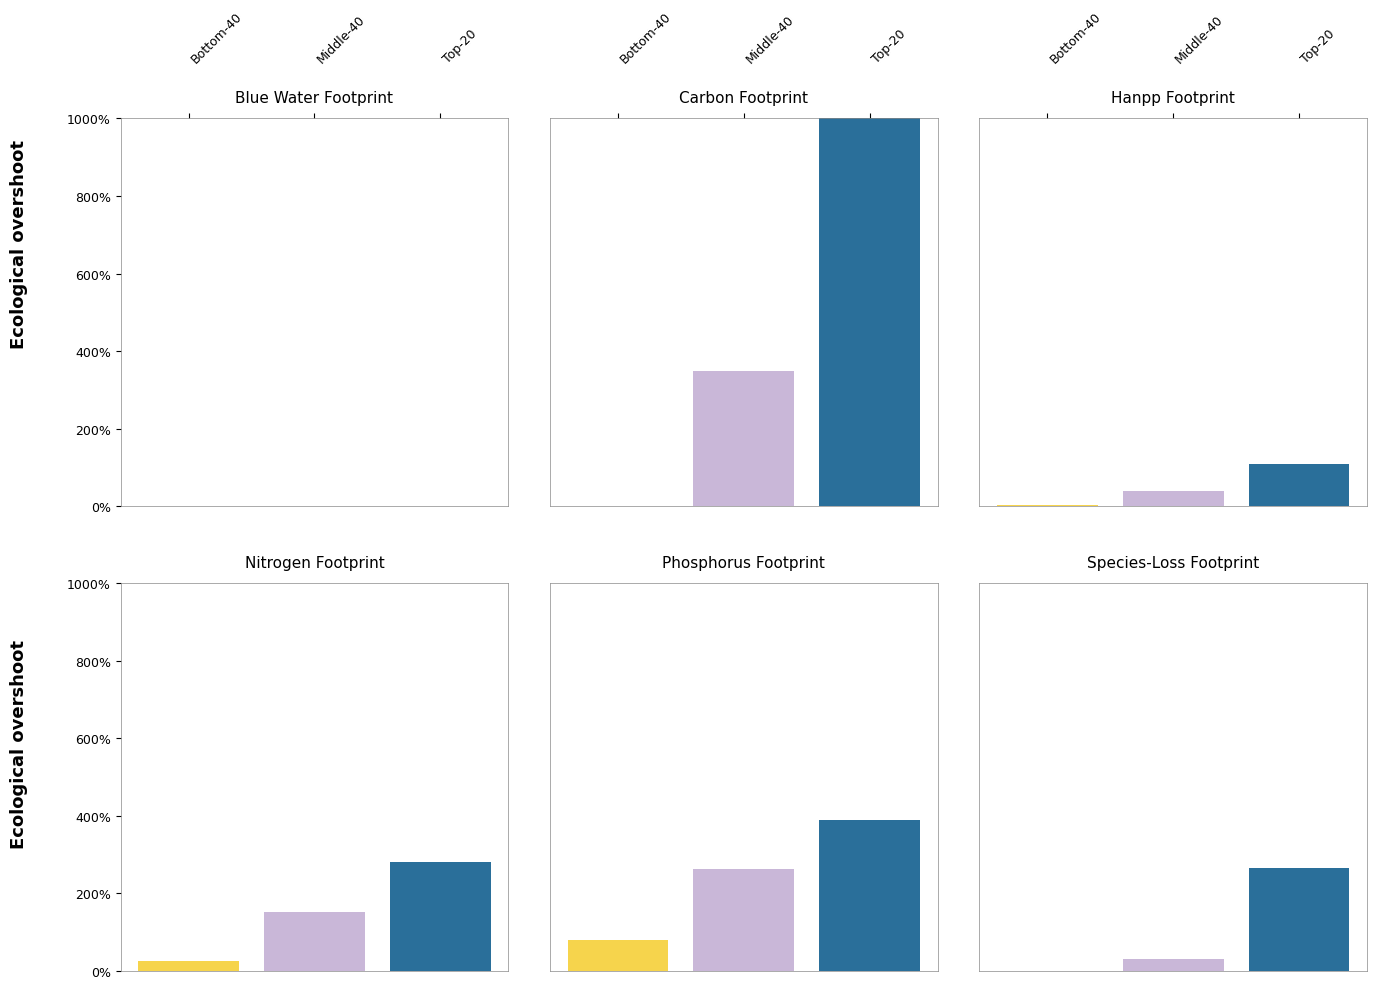

In [8]:
df = df_eco.copy()

# Keep Indicators ending with `footprint`
footprint_indicators = df[df["indicator"].str.endswith("footprint")]["indicator"].unique()

# Keep only indicators that have all three income groups
valid_indicators = []
for ind in footprint_indicators:
    temp = df[
        (df["indicator"] == ind) &
        (df["group"].isin(selected_groups))
    ]
    if len(temp) == 3:
        valid_indicators.append(ind)

# Alphabetical order (case-insensitive)
valid_indicators = sorted(valid_indicators, key=str.lower)

# Plot layout (2 × 3)
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, indicator) in enumerate(zip(axes, valid_indicators)):

    filtered = df[
        (df["indicator"] == indicator) &
        (df["group"].isin(selected_groups))
    ]

    # Sort rows so bars appear in correct order
    filtered = filtered.set_index("group").loc[selected_groups].reset_index()

    # Plot bars
    ax.bar(filtered["group"], filtered["shortfallOvershoot_pct"],
           color=[colors[g] for g in filtered["group"]],
           edgecolor="none")

    # Y-axis formatting
    ax.set_ylim(0, 1000)
    ax.set_yticks(np.arange(0, 1100, 200))
    # Only show Y-labels for the first column (index 0 and 3)
    if i % 3 == 0:
        ax.set_yticklabels([f"{x}%" for x in range(0, 1100, 200)])
        ax.tick_params(axis="y", left=True, labelleft=True, labelsize=9)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis="y", left=False, labelleft=False)

    # X-axis formatting
    ax.set_xticks(range(len(filtered["group"])))
    # Only show X-labels (top) for the first row (indices 0, 1, 2)
    if i < 3:
        ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, pad=35)
        ax.set_xticklabels(filtered["group"], rotation=45, ha="left", fontsize=9)
    else:
        ax.tick_params(axis='x', top=False, labeltop=False, bottom=False, labelbottom=False)
        ax.set_xticklabels([])

    # Title per graph
    ax.set_title(indicator.replace("_", " ").title(), fontsize=11, y=1.02)

    # Gridlines and spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_color("#888")


# Row titles: "Ecological overshoot" for each row
fig.text(0.02, 0.75, "Ecological overshoot", va="center", rotation="vertical", fontsize=13, fontweight="bold")
fig.text(0.02, 0.25, "Ecological overshoot", va="center", rotation="vertical", fontsize=13, fontweight="bold")

plt.tight_layout(h_pad=3, w_pad=3, rect=[0.05, 0, 1, 1])
plt.show()

### Social Shortfall Indicator Trellis plot

Ιδια λογικη με πριν

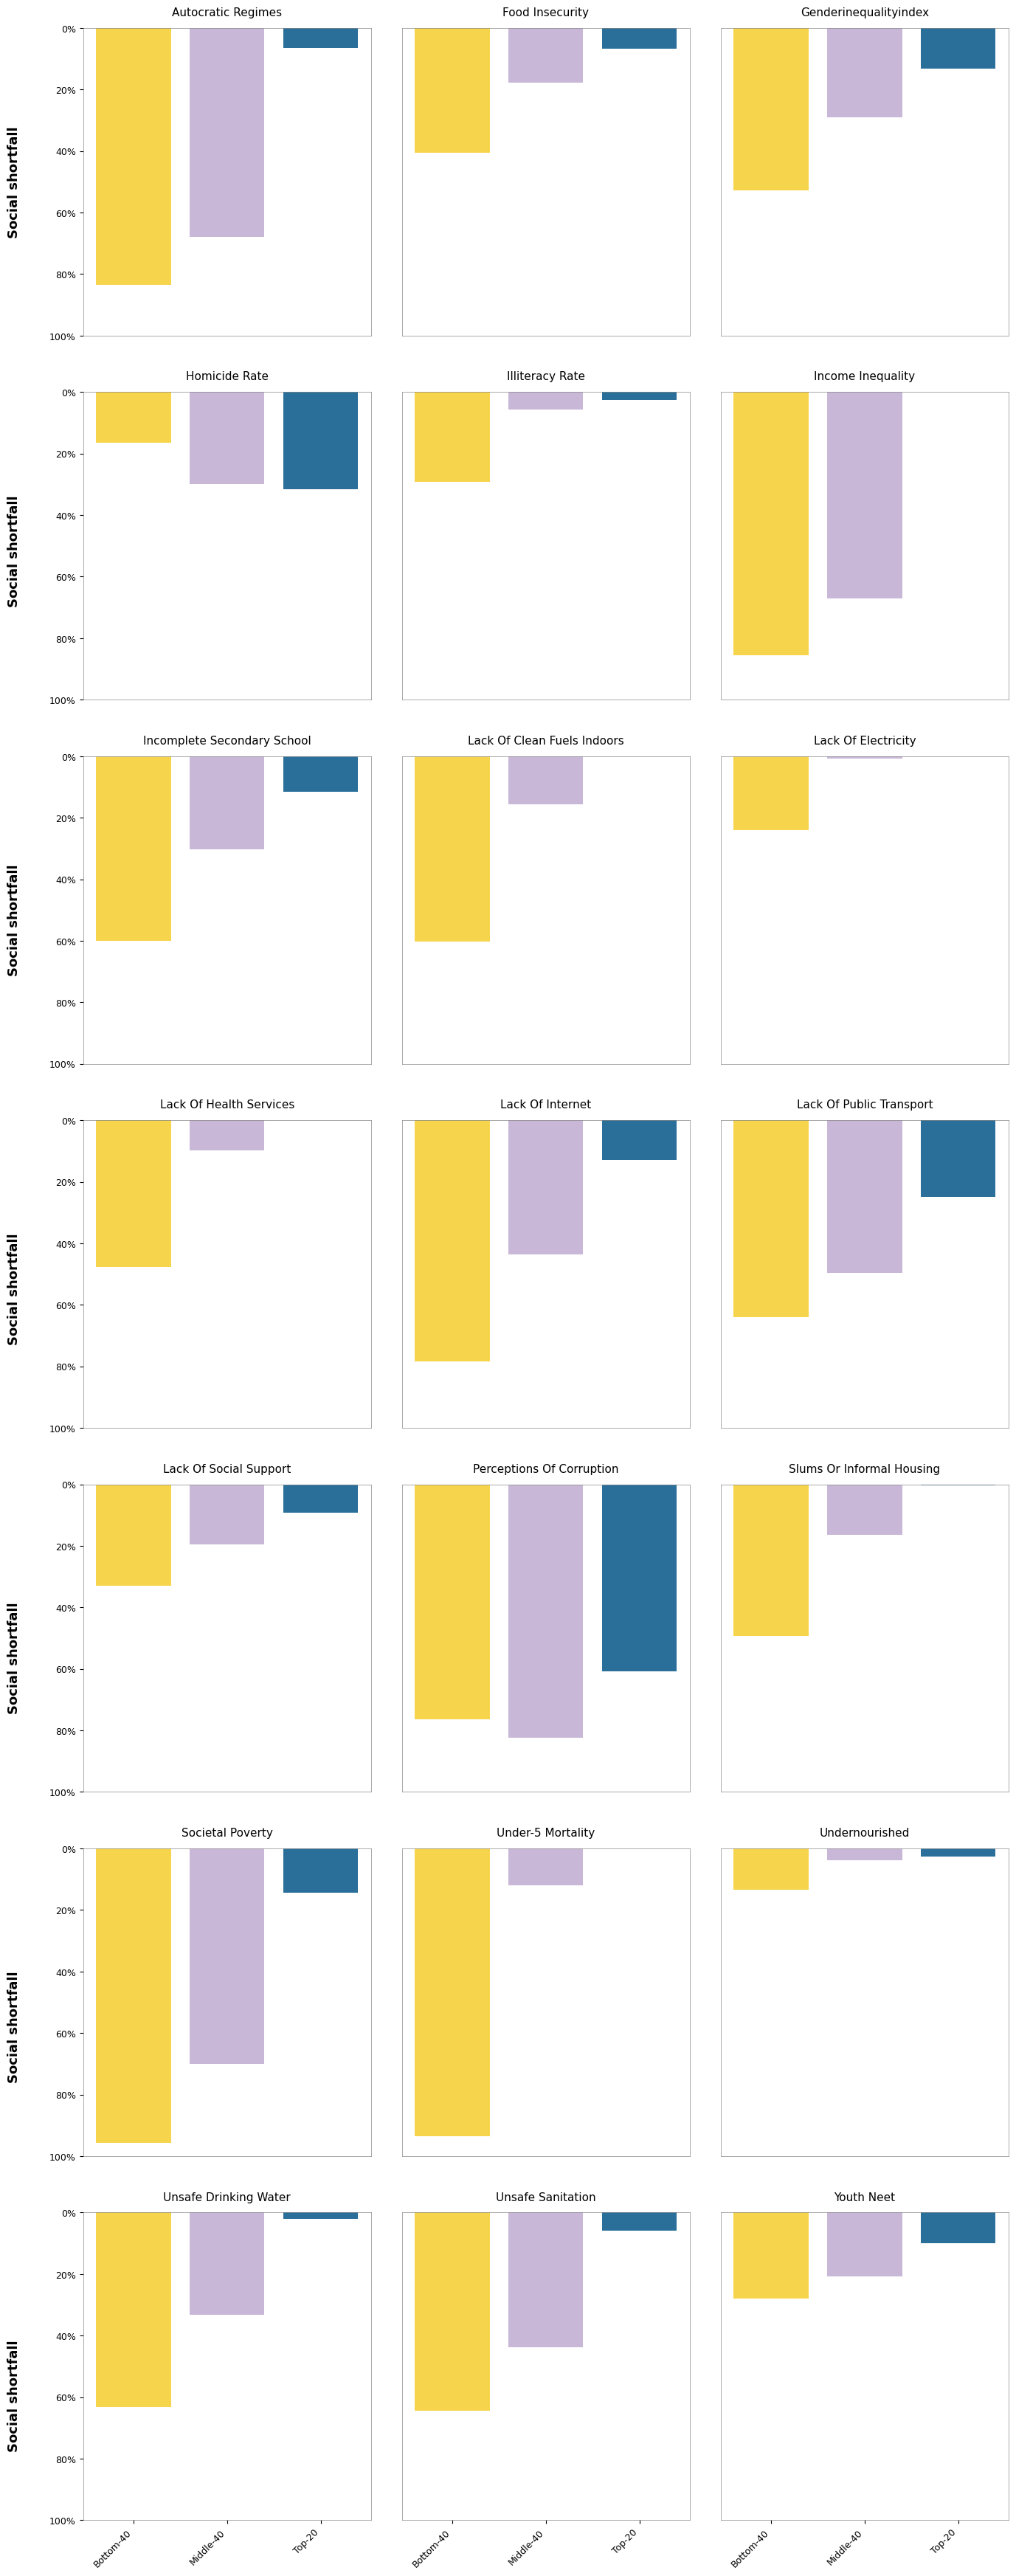

In [9]:
df = df_soc.copy()

# Find valid indicators with all three groups
all_unique = df["indicator"].unique()
valid_indicators = []

for ind in all_unique:
    temp = df[
        (df["indicator"] == ind) &
        (df["group"].isin(selected_groups))
    ]
    if len(temp) == 3:
        valid_indicators.append(ind)

# Sort them alphabetically
valid_indicators = sorted(valid_indicators, key=str.lower)

# Calculate grid based on valid count
num_indicators = len(valid_indicators)
cols = 3
rows = math.ceil(num_indicators / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 5))
axes = axes.flatten()

for i, (ax, indicator) in enumerate(zip(axes, valid_indicators)):

    filtered = df[
        (df["indicator"] == indicator) &
        (df["group"].isin(selected_groups))
    ]

    # Ensure bars are in the correct group order
    filtered = filtered.set_index("group").reindex(selected_groups).reset_index()

    # Plot bars inverted for shortfall
    ax.bar(filtered["group"], -filtered["shortfallOvershoot_pct"],  # invert values
           color=[colors[g] for g in filtered["group"]],
           edgecolor="none")

    # Y-axis 0–100%
    ax.set_ylim(-100, 0)
    ax.set_yticks(np.linspace(0, -100, 6))
    if i % cols == 0:
        ax.set_yticklabels([f"{abs(int(x))}%" for x in np.linspace(0, -100, 6)])
        ax.tick_params(axis="y", left=True, labelleft=True, labelsize=9)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis="y", left=False, labelleft=False)

    # X-axis formatting
    ax.set_xticks(range(len(filtered["group"])))

    row_index = i // cols
    is_last_row = (row_index == rows - 1)

    if is_last_row:
        # Show labels at the BOTTOM
        ax.tick_params(axis='x', top=False, labeltop=False, bottom=True, labelbottom=True)
        ax.set_xticklabels(filtered["group"], rotation=45, ha="right", fontsize=9)
    else:
        # Hide labels and ticks
        ax.tick_params(axis='x', top=False, labeltop=False, bottom=False, labelbottom=False)
        ax.set_xticklabels([])

    # Title per graph
    ax.set_title(indicator.replace("_", " ").title(), fontsize=11, y=1.02)

    # Grid lines and spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_color("#888")

# Remove any unused axes
for ax in axes[num_indicators:]:
    fig.delaxes(ax)

# Row titles
for i in range(rows):
    y_pos = 1 - (i + 0.5)/rows  # center of each row
    fig.text(0.02, y_pos, "Social shortfall", va="center", rotation="vertical",
             fontsize=13, fontweight="bold")

plt.tight_layout(h_pad=3, w_pad=3, rect=[0.05, 0, 1, 1])
plt.show()

## Sandwich Plot

Για το sandwich plot σκοπος ειναι να μεσω 2 bar charts (1 για τo eco και 1 inverted για το soc απο κατω) να δειξω πως σε καθε κατηγορια χειροτερεψε ή βελτιωθηκαν το ποσοστα απο το first και last record τους

### Collecting and Preparing the Data for the Sandwich PLot

κανω το table Multindexed με first και last για να κρινω την εγινε στο indicator και κανω map καποια columns με σκοπο user readability και για να κανουν match με το example outcome της εκφωνησης της εργασιας

In [10]:
sd_df = pd.read_excel(excel_url, sheet_name="global_2000-2022")

sd_df = sd_df[['domain', 'dimension', 'indicator', 'date', 'value', 'shortfallOvershoot_pct']].copy()
sd_df = sd_df.dropna(subset=['shortfallOvershoot_pct'])
sd_df = sd_df.dropna(subset=['value'])

df_eco = sd_df[sd_df["domain"] == "ecological"].copy()
df_soc = sd_df[sd_df["domain"] == "social"].copy()

# 1. Prepare data (Sort)
df_eco = df_eco.sort_values("date")

# 2. Group and Aggregate (Named Aggregation)
df_eco = df_eco.groupby(['dimension', 'indicator']).agg(
    date_first=('date', 'min'),
    date_last=('date', 'max'),
    shortfallOvershoot_pct_first=('shortfallOvershoot_pct', 'first'),
    shortfallOvershoot_pct_last=('shortfallOvershoot_pct', 'last')
).reset_index()

# 3. Set negative values to 0
cols_to_clip = ['shortfallOvershoot_pct_first', 'shortfallOvershoot_pct_last']
df_eco[cols_to_clip] = df_eco[cols_to_clip].clip(lower=0)

# 1. Update values to match the Graph Titles
eco_indicator_mapping = {
    'interhemAOD': 'Aerosol optical depth',
    'extinction1900': 'Species extinctions',
    'hanppGtC': 'Human appropriation of energy production',
    'chemicalsMt': 'Hazardous chemicals production',
    'chemicalsMt_Hzd': 'Hazardous chemicals production',
    'co2_ppm': 'CO2 concentration',
    'erf_wm2': 'Radioactive forcing',
    'blueDev': 'Blue-water flows',
    'soilDev': 'Soil moisture',
    'forestAreaMKM2': 'Forest area',
    'nitrogenMt': 'Nitrogen pollution',
    'phosphorusMt': 'Phosphorus pollution',
    'omega_a': 'Aragonite saturation',
    'totalOzone': 'Stratospheric ozone concentration',
}

# 2. Apply the replacement
df_eco['indicator'] = df_eco['indicator'].replace(eco_indicator_mapping)

# ==========================================
# SOCIAL DATA CLEANING

# 1. Prepare data (Sort)
df_soc = df_soc.sort_values("date")

# 2. Group and Aggregate (Named Aggregation)
df_soc = df_soc.groupby(['dimension', 'indicator']).agg(
    date_first=('date', 'min'),
    date_last=('date', 'max'),
    value_first=('value', 'first'),
    value_last=('value', 'last')
).reset_index()

# 3. Set negative values to 0
cols_to_clip = ['value_first', 'value_last']
df_soc[cols_to_clip] = df_soc[cols_to_clip].clip(lower=0)

# 1. Update values to match the Graph Titles
soc_indicator_mapping = {
    'internet': 'Lack of internet',
    'publicTrans': 'Lack of public transport',
    'adultLiteracy': 'Illiteracy',
    'secondarySchool': 'Incomplete secondary school',
    'energyAccess': 'Lack of electricity',
    'energyIndoor': 'Lack of clean fuels indoors',
    'genderInequalityIndex': 'Gender inequality',
    'foodInsecurity': 'Food insecurity',
    'undernourishment': 'Undernourishment',
    'UHCindex': 'Lack of health services',
    'under5death': 'Child mortality',
    'urbanSlums': 'Inadequate housing',
    'societalPoverty': 'Societal poverty',
    'youthNEET': 'Youth unemployment',
    'controlCorruption': 'Perceptions of corruption',
    'homicideOver5': 'Homicides',
    'govRegimes': 'Autocratic regimes',
    'palma': 'Income inequality',
    'socialSupport': 'Lack of social support',
    'drinkingH2O': 'Unsafe drinking water',
    'sanitation': 'Unsafe sanitation',
}

# 2. Apply the replacement
df_soc['indicator'] = df_soc['indicator'].replace(soc_indicator_mapping)


### Create Sandwich Plot using previous Data

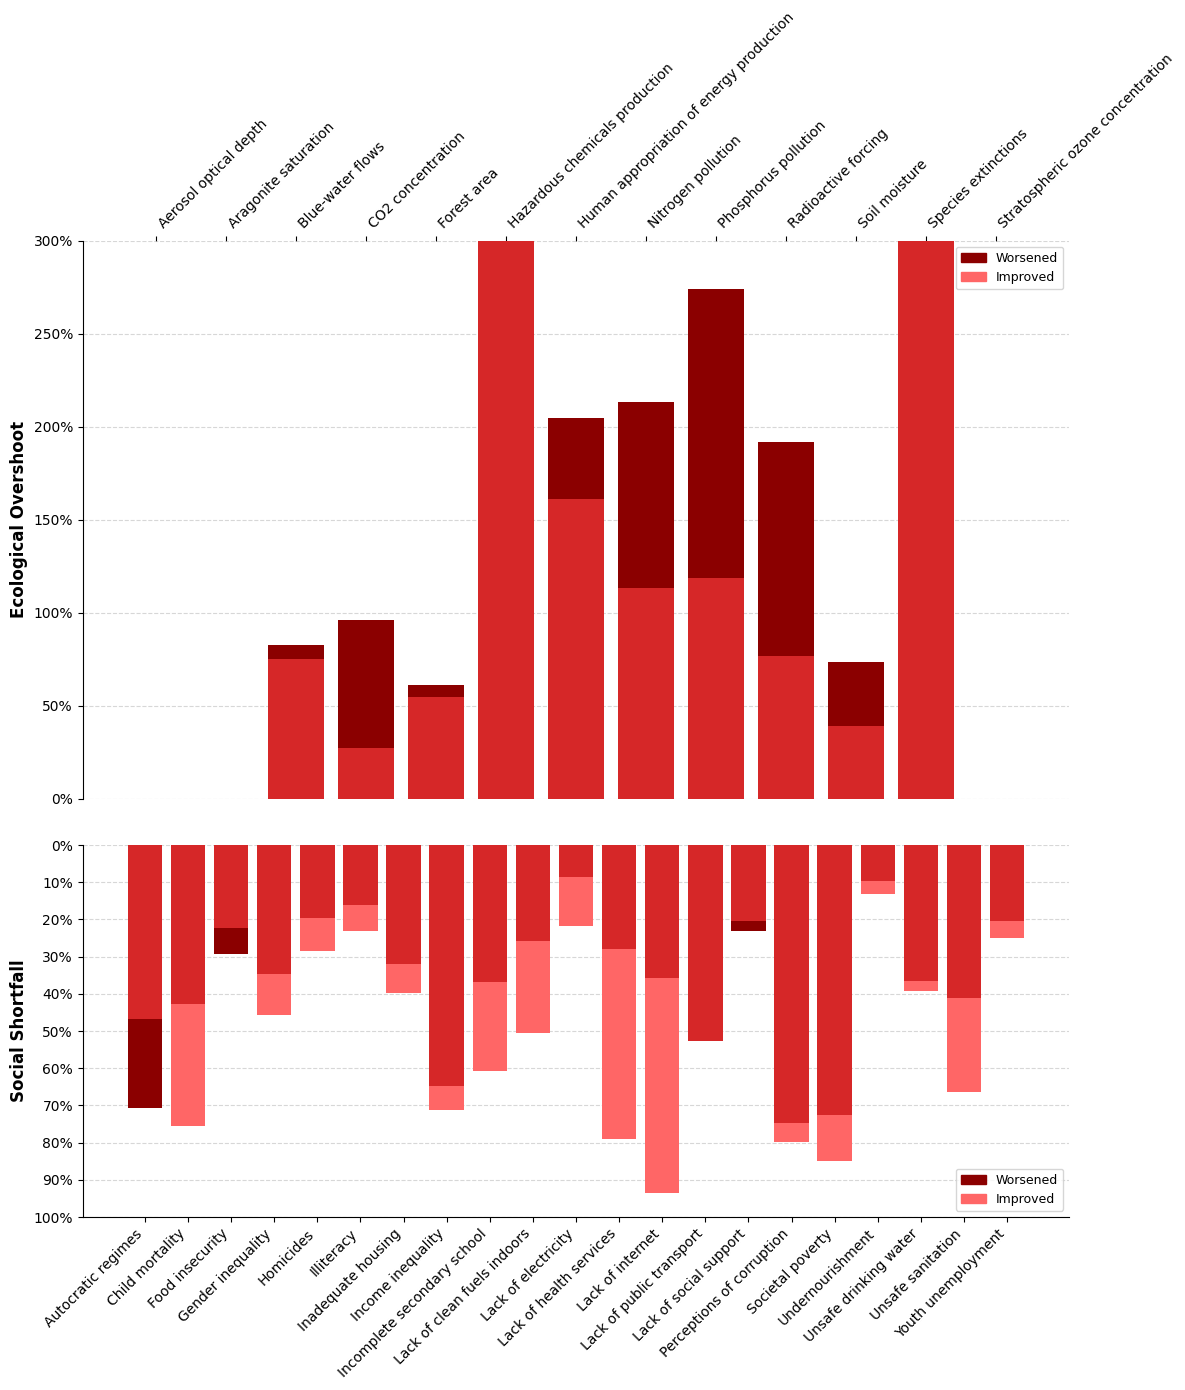

In [11]:
# Sort by 'indicator' immediately to ensure alphabetical order
df_eco = df_eco.copy().sort_values("indicator") 
df_soc = df_soc.copy().sort_values("indicator")

# define colors
C_STD_RED   = '#d62728'   # Base
C_LIGHT_RED = '#8b0000'   # Worsening
C_DARK_RED  = '#ff6666'   # Improvement

# plotting setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1.5, 1]})

# legend patches
light_patch = mpatches.Patch(color=C_LIGHT_RED, label='Worsened')
dark_patch  = mpatches.Patch(color=C_DARK_RED, label='Improved')

# Top Plot: Ecological Overshoot
if not df_eco.empty:
    x_idxs_eco = range(len(df_eco))
    ax1.set_axisbelow(True)
    ax1.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

    for i in x_idxs_eco:
        first = abs(df_eco.iloc[i]['shortfallOvershoot_pct_first'])
        last = abs(df_eco.iloc[i]['shortfallOvershoot_pct_last'])
        
        if last >= first:
            # CASE 1: INCREASE (Overshoot got worse)
            ax1.bar(i, last, color=C_LIGHT_RED, zorder=2) # Background: Lighter Red (Tall) represents the new extent
            ax1.bar(i, first, color=C_STD_RED, zorder=3) # Foreground: Standard Red (Short) represents the original extent
        else:
            # CASE 2: DECREASE (Overshoot improved)
            ax1.bar(i, first, color=C_DARK_RED, zorder=2) # Background: Darker Red (Tall) represents the OLD extent (what was removed)
            ax1.bar(i, last, color=C_STD_RED, zorder=3) # Foreground: Standard Red (Short) represents the CURRENT extent

    # Formatting Top
    ax1.set_ylim(0, 300)
    ax1.set_yticks(np.arange(0, 350, 50))
    ax1.set_yticklabels([f"{y}%" for y in np.arange(0, 350, 50)])
    ax1.set_ylabel("Ecological Overshoot", fontsize=12, fontweight='bold')
    
    # X-Axis to TOP
    ax1.xaxis.tick_top()
    ax1.set_xticks(x_idxs_eco)
    ax1.set_xticklabels(df_eco["indicator"], rotation=45, ha='left')
    
    # Spines
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    ax1.legend(handles=[light_patch, dark_patch], loc='upper right', fontsize=9)


# Bottom plot: Social Shortfall
if not df_soc.empty:
    x_idxs_soc = range(len(df_soc))
    ax2.set_axisbelow(True)
    ax2.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

    for i in x_idxs_soc:
        first = abs(df_soc.iloc[i]['value_first'])
        last = abs(df_soc.iloc[i]['value_last'])
        
        if last >= first:
            # CASE 1: INCREASE (Shortfall got deeper/worse)
            ax2.bar(i, last, color=C_LIGHT_RED, zorder=2) # Background: Lighter Red (Tall)
            ax2.bar(i, first, color=C_STD_RED, zorder=3) # Foreground: Standard Red (Short)
        else:
            # CASE 2: DECREASE (Shortfall shrank/improved)
            ax2.bar(i, first, color=C_DARK_RED, zorder=2) # Background: Darker Red (Tall) represents the OLD deep extent
            ax2.bar(i, last, color=C_STD_RED, zorder=3) # Foreground: Standard Red (Short) represents the CURRENT shallow extent

    # Formatting Bottom
    ax2.set_ylim(100, 0) # Inverted
    yticks_bot = np.arange(0, 110, 10)
    ax2.set_yticks(yticks_bot)
    ax2.set_yticklabels([f"{y}%" for y in yticks_bot])
    ax2.set_ylabel("Social Shortfall", fontsize=12, fontweight='bold')

    # X-Axis at BOTTOM
    ax2.set_xticks(x_idxs_soc)
    ax2.set_xticklabels(df_soc["indicator"], rotation=45, ha='right')

    # Spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    
    ax2.legend(handles=[light_patch, dark_patch], loc='lower right', fontsize=9)

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

## Doughnut Plot

Σκοπος εδω ειναι να δειξω τα percentages των Indicators και των 2 μας κατηγοριων την χρονολογια 2022 σε μορφη doughnut economics plot.<br>
Concept της συγγραφεας μας Kate Raworth

### Preparing the Data for the Doughnut Plot

First Collect and Prep the Data necessary for the Doughnut Plot

In [12]:
sd_df = pd.read_excel(excel_url, sheet_name="global_2000-2022")

sd_df = sd_df[['domain', 'dimension', 'indicator', 'date', 'value' , 'shortfallOvershoot_pct']].copy()

sd_df = sd_df[sd_df['date'] == 2022].copy()

sd_df = sd_df.drop("date", axis=1)

sd_df = sd_df.dropna(subset=["shortfallOvershoot_pct"])
sd_df = sd_df.dropna(subset=["value"])

sd_df['shortfallOvershoot_pct'] = sd_df['shortfallOvershoot_pct'].clip(lower=0)
sd_df['value'] = sd_df['value'].clip(lower=0)

sd_df['pct'] = np.where(
    sd_df['domain'] == 'social',
    sd_df['value'],
    sd_df['shortfallOvershoot_pct']
)

sd_df = sd_df.drop(['value', 'shortfallOvershoot_pct'], axis=1)

eco = sd_df[sd_df["domain"] == "ecological"].copy()
soc = sd_df[sd_df["domain"] == "social"].copy()

eco = eco.reset_index(drop=True)
soc = soc.reset_index(drop=True)

Update Indicator names for Readability / User Friendliness

In [13]:
# 1. Update values to match the Graph Titles
eco_indicator_mapping = {
    'interhemAOD': 'Aerosol optical depth',
    'extinction1900': 'Species extinctions',
    'hanppGtC': 'Human appropriation of energy production',
    'chemicalsMt': 'Hazardous chemicals production',
    'chemicalsMt_Hzd': 'Hazardous chemicals production',
    'co2_ppm': 'CO2 concentration',
    'erf_wm2': 'Radioactive forcing',
    'blueDev': 'Blue-water flows',
    'soilDev': 'Soil moisture',
    'forestAreaMKM2': 'Forest area',
    'nitrogenMt': 'Nitrogen pollution',
    'phosphorusMt': 'Phosphorus pollution',
    'omega_a': 'Aragonite saturation',
    'totalOzone': 'Stratospheric ozone concentration',
}

# 2. Apply the replacement
eco['indicator'] = eco['indicator'].replace(eco_indicator_mapping)

# 1. Update values to match the Graph Titles
soc_indicator_mapping = {
    'internet': 'Lack of internet',
    'publicTrans': 'Lack of public transport',
    'adultLiteracy': 'Illiteracy',
    'secondarySchool': 'Incomplete secondary school',
    'energyAccess': 'Lack of electricity',
    'energyIndoor': 'Lack of clean fuels indoors',
    'genderInequalityIndex': 'Gender inequality',
    'foodInsecurity': 'Food insecurity',
    'undernourishment': 'Undernourishment',
    'UHCindex': 'Lack of health services',
    'under5death': 'Child mortality',
    'urbanSlums': 'Inadequate housing',
    'societalPoverty': 'Societal poverty',
    'youthNEET': 'Youth unemployment',
    'controlCorruption': 'Perceptions of corruption',
    'homicideOver5': 'Homicides',
    'govRegimes': 'Autocratic regimes',
    'palma': 'Income inequality',
    'socialSupport': 'Lack of social support',
    'drinkingH2O': 'Unsafe drinking water',
    'sanitation': 'Unsafe sanitation',
}

# 2. Apply the replacement
soc['indicator'] = soc['indicator'].replace(soc_indicator_mapping)

#### Create linear Bar Charts to Understand Data First (Optional)

Αυτο το κομματι ειναι τελειως προαιρετικο αλλα με βοηθησε στην κατανοηση του graph σε πιο βασικο επιπεδο πριν προχωρισω στο doughnut version

Inner Bars (Societal Shortfalls)

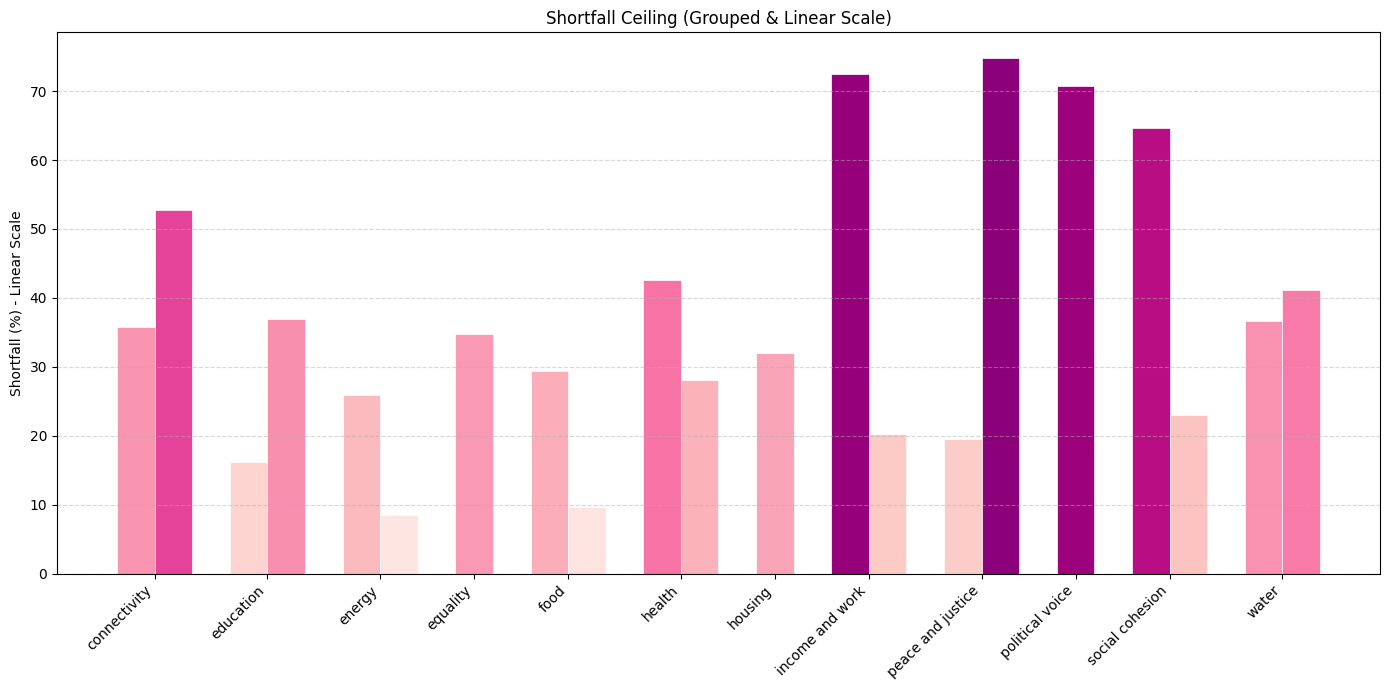

In [14]:
# 2. Sort Data (CRITICAL for grouping)
# We must sort by dimension so bars of the same group appear sequentially
soc = soc.sort_values(by=['dimension', 'indicator'])

# 3. Calculate Positions for "Touching" Bars
# Logic: Increment X by 'bar_width' (touching), add extra 'gap' when dimension changes
x_coords = []
bar_colors = []
current_x = 0
bar_width = 1.0       # Width of the bar
group_gap = 1.0       # Gap between different dimensions
last_dimension = None

for dim in soc['dimension']:
    if last_dimension is not None and dim != last_dimension:
        current_x += group_gap # Add gap if new dimension
    
    x_coords.append(current_x)
    current_x += bar_width # Move forward by exactly one bar width
    last_dimension = dim

# 4. Calculate Colors (Taller = Darker)
# Normalize height values to range [0, 1] for the colormap
min_h, max_h = soc['pct'].min(), soc['pct'].max()
norm = mcolors.Normalize(vmin=0, vmax=max_h * 1.2) # *1.2 ensures max isn't pitch black/too clipped
# 'RdPu' is a Red-Purple colormap similar to your previous pink theme. 
# You can also use 'Reds', 'PuRd', or 'YlOrRd'.
colormap = plt.get_cmap('RdPu') 
bar_colors = colormap(norm(soc['pct']))

# 5. Create the Plot
plt.figure(figsize=(14, 7))

# width=bar_width ensures they touch since our step size is also bar_width
bars = plt.bar(x_coords, soc['pct'], width=bar_width, color=bar_colors, edgecolor='white', linewidth=0.5)

# 6. Formatting
# Calculate the center x-position for each dimension group
tick_df = pd.DataFrame({'dimension': soc['dimension'], 'x': x_coords})
group_centers = tick_df.groupby('dimension', sort=False)['x'].mean()

# Set the x-ticks to be at those center positions with 45 degree rotation
plt.xticks(group_centers.values, group_centers.index, rotation=45, ha='right', fontsize=10)

plt.ylabel('Shortfall (%) - Linear Scale')
plt.title('Shortfall Ceiling (Grouped & Linear Scale)')

plt.grid(axis='y', which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Outer Bars (Ecological Overshoot)

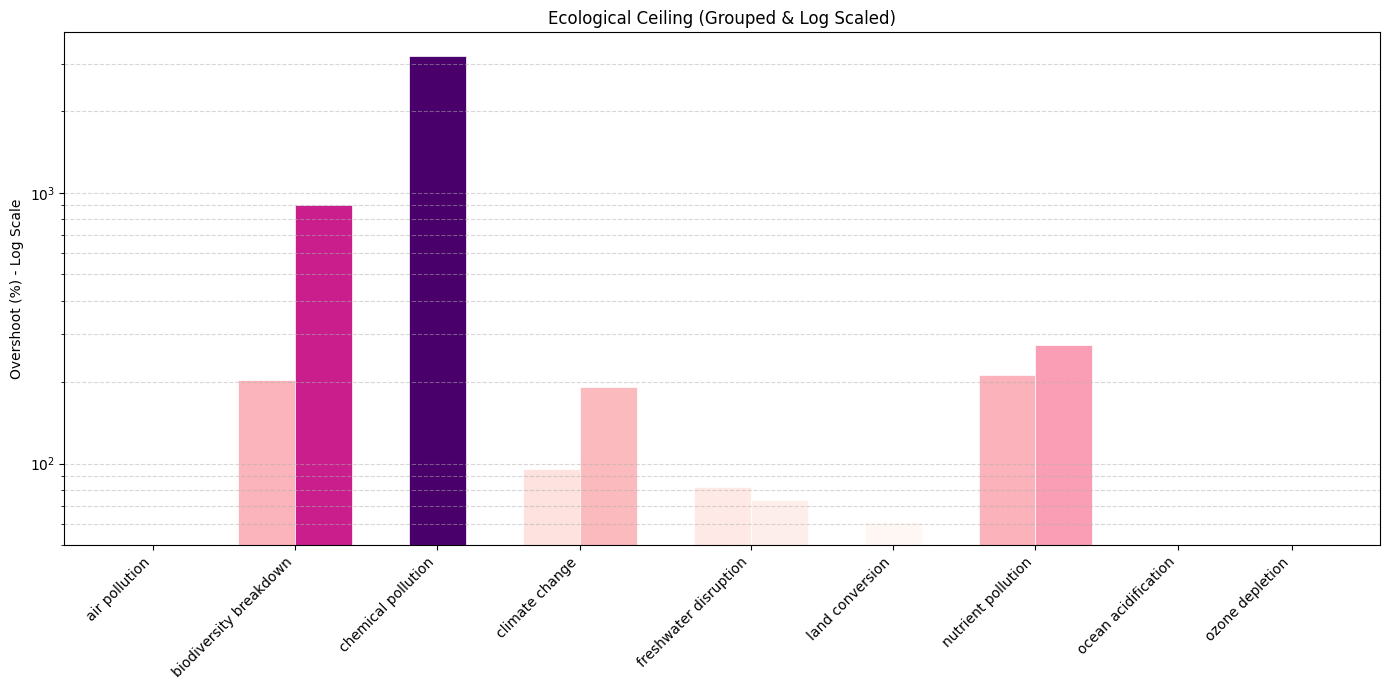

In [15]:
# 2. Sort Data (CRITICAL for grouping)
eco = eco.sort_values(by=['dimension', 'indicator'])

# 3. Calculate Positions for "Touching" Bars
x_coords = []
bar_colors = []
current_x = 0
bar_width = 1.0       
group_gap = 1.0       
last_dimension = None

for dim in eco['dimension']:
    if last_dimension is not None and dim != last_dimension:
        current_x += group_gap 
    
    x_coords.append(current_x)
    current_x += bar_width 
    last_dimension = dim

# 4. Calculate Colors (Logarithmic Gradient)
# We use LogNorm so the color gradient matches the visual log scale
# vmin must be > 0. We use the minimum non-zero value or a small epsilon.
min_val = eco[eco['pct'] > 0]['pct'].min()
norm = mcolors.LogNorm(vmin=min_val, vmax=eco['pct'].max()) 

colormap = plt.get_cmap('RdPu') 
bar_colors = colormap(norm(eco['pct']))

# 5. Create the Plot
plt.figure(figsize=(14, 7))

# 'log=True' enables the logarithmic scale on the Y-axis
bars = plt.bar(x_coords, eco['pct'], width=bar_width, color=bar_colors, edgecolor='white', linewidth=0.5, log=True)

# 6. Formatting
# 6. Formatting
# Calculate the center x-position for each dimension group
tick_df = pd.DataFrame({'dimension': eco['dimension'], 'x': x_coords})
group_centers = tick_df.groupby('dimension', sort=False)['x'].mean()

# Set the x-ticks to be at those center positions with 45 degree rotation
plt.xticks(group_centers.values, group_centers.index, rotation=45, ha='right', fontsize=10)

plt.ylabel('Overshoot (%) - Log Scale')
plt.title('Ecological Ceiling (Grouped & Log Scaled)')

plt.grid(axis='y', which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Recreating It

Τα σημαντικα visualization χαρακτηρηστικα που προσπαθω παρακατω να κανω recreate ειναι ,<br>
- Doughnut Formed Graph (Obviously)
- values for both domain clear and separated by Green circle representing boundary
- space efficient labeling
- Color gradient (Bigger pct = darker, smaller = lighter)
- Dynamic Scaling (Εγω για τα eco values χρησιμοποισα Power scaling που διχνει διαφορα σε χαμηλοτερες τιμες χωρις να επιτρεπει τις πολυ μεγαλυτερες να χαλανε το graph. Δοκιμασα log scaling αλλα μειωνε πολυ το βαρος των μεγαλων τιων)(για τα soc εφοσον ολα ηταν 0 -100 linear scale was suffice)
- indicators grouped together by dimension
- Interactiveness using plotly (browser endering, hover fore exact stats, zoom)

In [16]:
# Configuration
SOCIAL_LIMIT = 380      # Social ring
ECO_LIMIT = 650         # Eco ring
RING_WIDTH = 40       # Ring thickness
GAP_SIZE = 5            # Gap between groups
CENTER_HOLE = 120       # Center hole

# Scaling
POWER_EXPONENT = 0.6
VISUAL_MULTIPLIER = 10

# Eco bar length
eco['visual_r'] = np.power(eco['pct'], POWER_EXPONENT) * VISUAL_MULTIPLIER

# Hover text
eco['hover_text'] = eco['indicator'] + ': ' + eco['pct'].astype(str) + '%'
soc['hover_text'] = soc['indicator'] + ': ' + soc['pct'].astype(str) + '%'

# Max radius
max_eco_visual = eco['visual_r'].max() if not eco.empty else 0
MAX_R = ECO_LIMIT + RING_WIDTH + max_eco_visual + 30

# Colors
COLOR_SAFE_FILL = '#76B947'
COLOR_SAFE_BORDER = '#145233'

# Gradient for bars
IMAGE_COLOR_SCALE = [
    [0.0, '#ffc4c4'],  
    [0.5, '#bd3e59'],  
    [1.0, '#4a081f']   
]

# Geometry
def process_data_with_geometry(df, gap_size=5):
    if 'dimension' not in df.columns:
        df['dimension'] = [f'Group {i//3}' for i in range(len(df))]
    df = df.sort_values(by=['dimension', 'indicator']).reset_index(drop=True)
    
    n = len(df)
    n_groups = df['dimension'].nunique()
    total_gap = n_groups * gap_size if (n_groups * gap_size) < 360 else 0
    bar_width = (360 - total_gap) / n
    
    thetas = []
    current_angle = 0
    for i in range(n):
        if i > 0 and df.loc[i, 'dimension'] != df.loc[i-1, 'dimension']:
            current_angle += gap_size
        thetas.append(current_angle + (bar_width / 2))
        current_angle += bar_width
        
    df['theta'] = thetas
    df['width'] = bar_width
    return df

# Process data
soc = process_data_with_geometry(soc, gap_size=GAP_SIZE)
eco = process_data_with_geometry(eco, gap_size=GAP_SIZE)

# Label positions
soc_labels = soc.groupby('dimension')['theta'].mean().reset_index()
eco_labels = eco.groupby('dimension')['theta'].mean().reset_index()

# Build Plot
fig = go.Figure()

# Rings
theta_circle = np.linspace(0, 360, 360)
def add_ring(r_inner, r_outer, color, name):
    fig.add_trace(go.Scatterpolar(
        r = [r_outer]*360 + [r_inner]*360,
        theta = np.concatenate([theta_circle, theta_circle[::-1]]),
        fill = 'toself', fillcolor = color, 
        line = dict(width=0), hoverinfo = 'skip', name = name,
        showlegend=False
    ))

add_ring(SOCIAL_LIMIT - RING_WIDTH, SOCIAL_LIMIT, COLOR_SAFE_BORDER, 'Social Foundation')
add_ring(SOCIAL_LIMIT, ECO_LIMIT, COLOR_SAFE_FILL, 'Safe Space')
add_ring(ECO_LIMIT, ECO_LIMIT + RING_WIDTH, COLOR_SAFE_BORDER, 'Ecological Ceiling')

# Social shortfall
inner_radius_start = SOCIAL_LIMIT - RING_WIDTH
available_length = inner_radius_start - CENTER_HOLE
soc['scaled_length'] = (soc['pct'] / 100) * available_length

fig.add_trace(go.Barpolar(
    r = soc['scaled_length'],
    theta = soc['theta'],
    width = soc['width'],
    base = inner_radius_start - soc['scaled_length'],
    marker = dict(
        color = soc['pct'], 
        colorscale = IMAGE_COLOR_SCALE, 
        cmin = 0, cmax = 100, line_width = 0
    ),
    name = 'Social Shortfall',
    text = soc['hover_text'], hoverinfo = 'text',
    showlegend=False
))

# Eco overshoot
fig.add_trace(go.Barpolar(
    r = eco['visual_r'],
    theta = eco['theta'],
    width = eco['width'],
    base = ECO_LIMIT + RING_WIDTH,
    marker = dict(
        color = eco['pct'],   
        colorscale = IMAGE_COLOR_SCALE,  
        cmin = 0, 
        cmax = max(100, eco['pct'].max() if not eco.empty else 100),
        line_width = 0
    ),
    name = 'Eco Overshoot',
    text = eco['hover_text'], hoverinfo = 'text',
    showlegend=False
))

# Labels
green_ring_midpoint = (SOCIAL_LIMIT + ECO_LIMIT) / 2

fig.add_trace(go.Scatterpolar(
    r = [green_ring_midpoint] * len(soc_labels), 
    theta = soc_labels['theta'],
    text = soc_labels['dimension'],
    mode = 'text', textposition = 'middle center',
    textfont = dict(size=8, color='white', weight='bold'), 
    hoverinfo='skip', showlegend=False
))

eco_label_pos = ECO_LIMIT + RING_WIDTH + 240
label_colors = ['white' if l.strip().lower() == 'chemical pollution' else 'black' 
                for l in eco_labels['dimension']]

fig.add_trace(go.Scatterpolar(
    r = [eco_label_pos] * len(eco_labels),
    theta = eco_labels['theta'],
    text = eco_labels['dimension'],
    mode = 'text', textposition = 'middle center',
    textfont = dict(size=10, color=label_colors, weight='bold'), 
    hoverinfo='skip', showlegend=False
))

# 5. Layout with Static Notes
fig.update_layout(
    title=dict(
        text='Doughnut Plot',
        x=0.5, y=0.95,
        xanchor='center', yanchor='top',
        font=dict(size=24)
    ),
    template='plotly_white',
    height=1000, 
    margin=dict(t=80, b=30, l=30, r=30),
    dragmode=False,
    polar = dict(
        radialaxis = dict(visible = False, range = [0, MAX_R]),
        angularaxis = dict(visible = False, direction = "clockwise"),
        hole = 0.0 
    ),
    showlegend=False,
    # Static Annotations "Like a Note"
    annotations=[
        dict(
            text="<b>Outer Ring</b> = Ecological Overshoot",
            x=0.0, y=1.02, xref='paper', yref='paper',
            showarrow=False, align='left',
            font=dict(size=12, color='black')
        ),
        dict(
            text="<b>Inner Ring</b> = Societal Shortfall",
            x=0.0, y=0.99, xref='paper', yref='paper',
            showarrow=False, align='left',
            font=dict(size=12, color='black')
        )
    ]
)

fig.show()

Αν θελετε να το δειτε στο browser:

In [17]:
fig.show(renderer="browser")